In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import eli5
from eli5.sklearn import PermutationImportance

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submit.csv")

In [3]:
train.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0


In [4]:
test.head()

,id,title,abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,NaN
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...


In [5]:
sample.head()

,27145,0
0,27146,1
1,27147,1
2,27148,0
3,27149,1
4,27150,0


In [6]:
print("trainデータ数：", len(train))
print("")
print("train欠損値の数\n", train.isnull().sum())

trainデータ数： 27145

train欠損値の数
 id              0
title           0
abstract     4390
judgement       0
dtype: int64


In [7]:
print("testデータ数：", len(test))
print("")
print("test欠損値の数\n", test.isnull().sum())

testデータ数： 40834

test欠損値の数
 id             0
title          0
abstract    6546
dtype: int64


Text(0.5, 1.0, 'Proportion of Judgement')

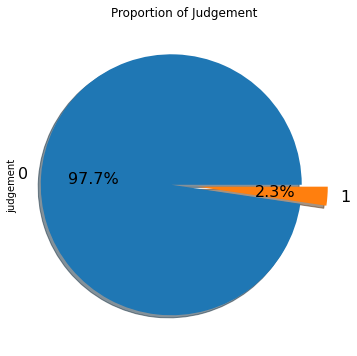

In [8]:
plt.figure(figsize=(6, 6))

train["judgement"].value_counts().plot.pie(explode=[0.1, 0.1], autopct="%1.1f%%", shadow=True, textprops={"fontsize": 16}).set_title("Proportion of Judgement")

AbstractがNANかどうかの特徴を作る

In [9]:
train["abstract_is_NAN"] = train["abstract"].apply(lambda x: str(x) == "nan").astype(int)
test["abstract_is_NAN"] = test["abstract"].apply(lambda x: str(x) == "nan").astype(int)

In [16]:
train.head()

,id,title,abstract,judgement,abstract_is_NAN
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1


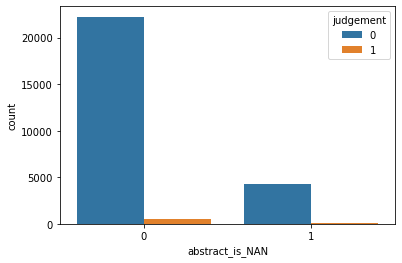

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x="abstract_is_NAN", hue="judgement")

In [84]:
train.head(20)

,id,title,abstract,judgement,abstract_is_NAN
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1
5,5,From bench to bedside: Molecular imaging in in...,Purpose of review Standard structural imaging ...,0,0
6,6,Left gonadal vein thrombosis in a patient with...,COVID-19 disease is a viral illness that predo...,0,0
7,7,Development and validation of a prediction mod...,OBJECTIVES: We aimed to develop and validate a...,0,0
8,8,Rehabilitation and Covid-19: the Cochrane Reha...,INTRODUCTION: This paper improves the methodol...,0,0
9,9,Slow gait in MCI is associated with ventricula...,Slow gait is ubiquitous among older adults and...,0,0


In [92]:
train[train["abstract"].isnull() & (train["judgement"] == 1)]["judgement"].sum()

122

In [94]:
train[train["judgement"] == 1]["judgement"].sum()

632